# Interpretability via SHAP Values 

CPH 200C Problem 3

Questions? Ask Professor Irene Chen (iychen@berkeley.edu)

As machine learning models become more inscrutable, we are interested in methods to better understand why our models make the decisions they do --- and as a result whether we can trust them. To address this problem, we typically apply either post-hoc explanations to trained models or restrict our models to specific classes that are deemed more easily understandable. The goal of this section of the problem set is to familiarize you with the SHAP values package to apply interpretability methods to the diabetes dataset we have already explored.


## 0. Load packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import seaborn as sns

from matplotlib import pyplot as plt


fname = '/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/data/diabetic_data.csv'

In [2]:
df = pd.read_csv(fname)

## 1. Clean Diabetes Dataset

Below please find some simple data cleaning. You may substitute if you prefer your data cleaning pipeline from Pset1

In [4]:
df['readmitted_bool'] = (df['readmitted'] == '<30')

In [5]:
df['max_glu_serum'] = df['max_glu_serum'].fillna('null')
df['A1Cresult'] = df['max_glu_serum'].fillna('null')

In [6]:
cat_cols = ['race', 'gender', 'age', 'weight',  'admission_type_id', 'discharge_disposition_id', 
            'admission_source_id', 'payer_code','medical_specialty','max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

val_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

cat_cols_all = []
df_all = []

for col in cat_cols:
    col_dummies = pd.get_dummies(df[col],col, drop_first=True)
    df_all.append(col_dummies)

cat_df = pd.concat(df_all,axis=1)

df['diag_1copy'] = df['diag_1'].copy()
counts = pd.value_counts(df['diag_1'])
mask = df['diag_1'].isin(counts[counts < 1000].index)
df['diag_1copy'][mask] = 'other'
diag_dummies = pd.get_dummies(df['diag_1copy'],drop_first=True)

diag_a1c = pd.get_dummies(df[['A1Cresult', 'diag_1copy']].apply(tuple, axis=1))
diag_a1c.columns = [i[0] + '_' + i[1] for i in diag_a1c.columns]


X = pd.concat([cat_df, diag_dummies, df[val_cols], diag_a1c], axis=1)
y = df['readmitted_bool']

/var/folders/5d/fz2jdmk530jfw8k__ywz47_r0000gn/T/ipykernel_77867/3328005027.py:24: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(df['diag_1'])
/var/folders/5d/fz2jdmk530jfw8k__ywz47_r0000gn/T/ipykernel_77867/3328005027.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diag_1copy'][mask] = 'other'


In [7]:
def clean(x):
    return x.replace('?', '').replace('<', 'less').replace('[','').replace(']','')

cols_clean = [clean(i) for i in X.columns]

X.columns = cols_clean

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,train_size=0.5)

In [9]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc",use_label_encoder=False)

clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5)
yhat = clf.predict_proba(X_test)[:,1]

/Users/hongzhouluan/opt/anaconda3/envs/cornerstoneproject/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.63192
[1]	validation_0-auc:0.65111
[2]	validation_0-auc:0.65559
[3]	validation_0-auc:0.65620
[4]	validation_0-auc:0.65790
[5]	validation_0-auc:0.65961
[6]	validation_0-auc:0.66196
[7]	validation_0-auc:0.66106
[8]	validation_0-auc:0.66228
[9]	validation_0-auc:0.66132
[10]	validation_0-auc:0.66213
[11]	validation_0-auc:0.66344
[12]	validation_0-auc:0.66451
[13]	validation_0-auc:0.66596
[14]	validation_0-auc:0.66573
[15]	validation_0-auc:0.66610
[16]	validation_0-auc:0.66633
[17]	validation_0-auc:0.66738
[18]	validation_0-auc:0.66857
[19]	validation_0-auc:0.66881
[20]	validation_0-auc:0.66940
[21]	validation_0-auc:0.66916
[22]	validation_0-auc:0.66857
[23]	validation_0-auc:0.66817
[24]	validation_0-auc:0.66850
[25]	validation_0-auc:0.66785


## 2. SHAP Value Interpretability

Please fill in the `TODO` comments to produce two plots:
 1. **Data-point-level interpretability**: Which features are most important for predicting this data point?
 2. **Model-level interpretability**: Which features are most important for positive and negative predictions?
 
You may find [this page](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html) helpful.

In [12]:
import shap
shap.initjs()

/Users/hongzhouluan/opt/anaconda3/envs/cornerstoneproject/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)

In [ ]:
# TODO: create force plot for one data point illustrating the expected value and the shape values
# calculate the expected value
expected_value = explainer.expected_value
print(expected_value)

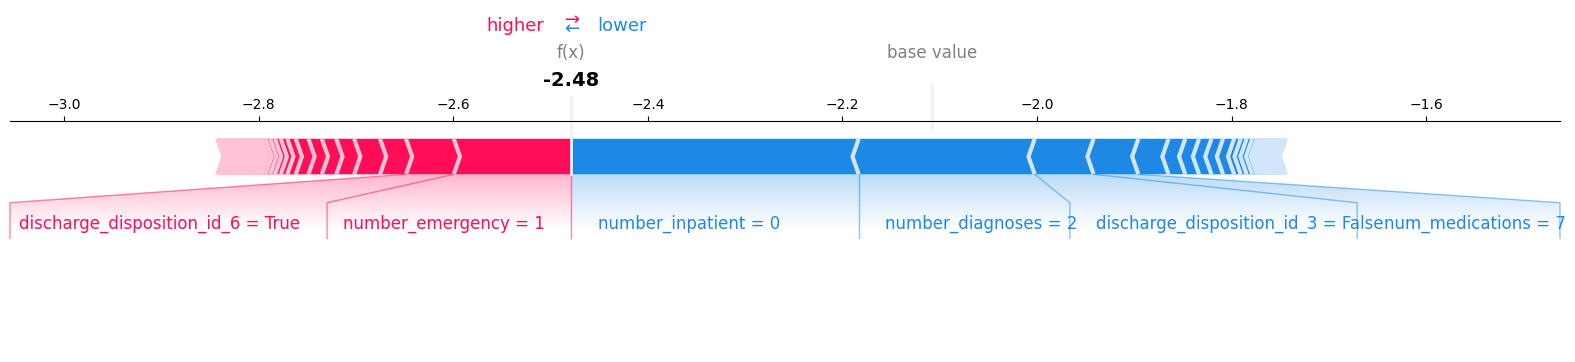

In [34]:
import matplotlib.pyplot as plt

shap.plots.force(shap_values[0])
shap.plots.force(shap_values[0], matplotlib=True)
plt.savefig('/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/plots/force_plot.png', bbox_inches='tight')
plt.close()

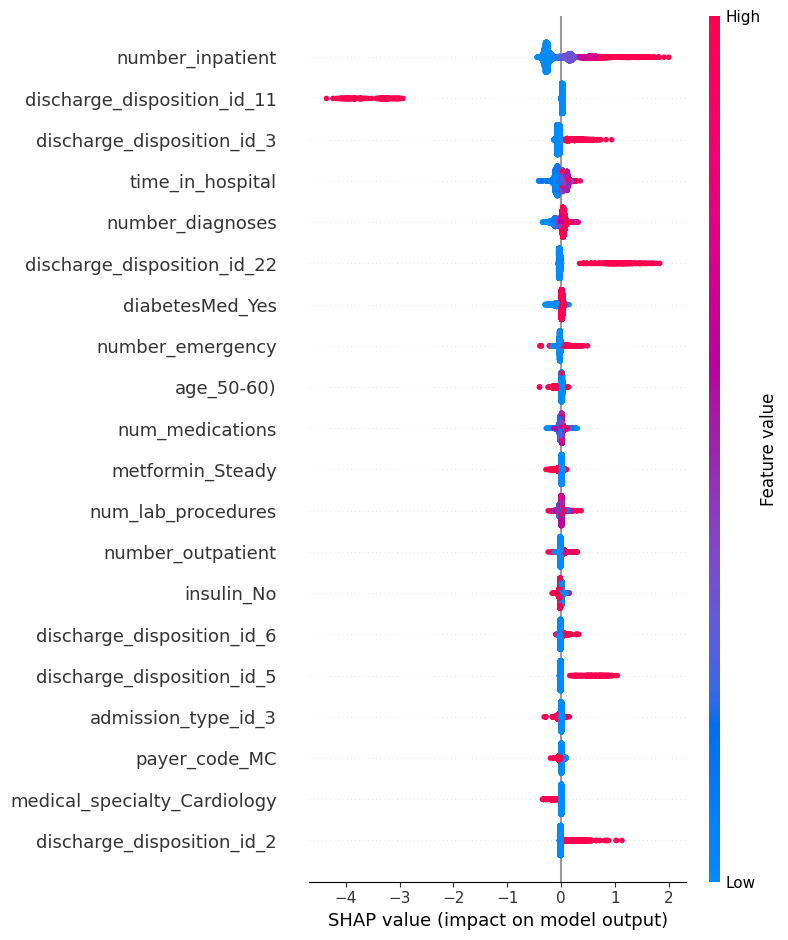

<Figure size 640x480 with 0 Axes>

In [36]:
# TODO: create summary plot of shape values for X_test
shap.summary_plot(shap_values, X_test)
plt.savefig('/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/plots/summary_plot.png', bbox_inches='tight')